<a href="https://colab.research.google.com/github/smplante02/adversarial-image-generation/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resources:
*   https://arxiv.org/pdf/1707.04131.pdf
*   https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
* https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory
* https://stackoverflow.com/questions/4803999/how-to-convert-a-file-into-a-dictionary
* https://foolbox.jonasrauber.de/guide/getting-started.html
* https://foolbox.readthedocs.io/en/latest/modules/attacks.html
* https://github.com/bethgelab/foolbox/blob/2513a9a8675d7017e5266d3b0ed89124cb436ec5/foolbox/plot.py
* https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/



---



In [ ]:
!pip3 install foolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [ ]:
import foolbox as fb
import tensorflow as tf
import eagerpy as ep
import numpy as np

In [ ]:
model = tf.keras.applications.ResNet50(weights="imagenet")
preprocessing = dict(flip_axis=-1, mean=[103.939, 116.779, 123.68])
bounds = (0, 255)
fmodel = fb.TensorFlowModel(model, bounds=bounds, preprocessing=preprocessing)
fmodel = fmodel.transform_bounds((0, 1))

images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=10)
images = ep.astensor(images)
labels = ep.astensor(labels)
criterion = fb.criteria.Misclassification(labels)

print("Regular ACCURACY: ", fb.utils.accuracy(fmodel, images, labels))

102967424/102967424 [==============================] - 1s 0us/step


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Regular ACCURACY:  0.8999999761581421


In [ ]:
distance = fb.distances.LpDistance(50.0)
attack = fb.attacks.LinearSearchBlendedUniformNoiseAttack(distance=distance)
raw, clipped, is_adv = attack(fmodel, images, criterion=criterion, epsilons=0.75)

In [ ]:
distance = fb.distances.LpDistance(50.0)
attack = fb.attacks.LinearSearchContrastReductionAttack(distance=distance)
raw2, clipped2, is_adv2 = attack(fmodel, images, criterion=criterion, epsilons=0.75)

KeyboardInterrupt: 

In [ ]:
attack = fb.attacks.LinfFastGradientAttack(random_start=True)
raw3, clipped3, is_adv3 = attack(fmodel, images, criterion=criterion, epsilons=0.3)

In [ ]:
# Modified version of foolbox image plotting to include multiple images in one row
from typing import Tuple, Any, Optional
import numpy as np
import eagerpy as ep


def imagesFunction(
  images1: Any,
  images2: Any,
  images3: Any,
  *,
  n1: Optional[int] = None,
  n2: Optional[int] = None,
  data_format: Optional[str] = None,
  bounds: Tuple[float, float] = (0, 1),
  ncols: Optional[int] = None,
  nrows: Optional[int] = None,
  figsize: Optional[Tuple[float, float]] = None,
  scale: float = 1,
  **kwargs: Any,
) -> None:
  import matplotlib.pyplot as plt

  x: ep.Tensor = ep.astensor(images1)
  if x.ndim != 4:
      raise ValueError(
          "expected images to have four dimensions: (N, C, H, W) or (N, H, W, C)"
      )
  x2: ep.Tensor = ep.astensor(images2)
  if x.ndim != 4:
      raise ValueError(
          "expected images to have four dimensions: (N, C, H, W) or (N, H, W, C)"
      )
  x3: ep.Tensor = ep.astensor(images3)
  if x.ndim != 4:
      raise ValueError(
          "expected images to have four dimensions: (N, C, H, W) or (N, H, W, C)"
      )

  if n1 is not None and n2 is not None:
      x = x[n1:n2]
      x2 = x2[n1:n2]
      x3 = x3[n1:n2]
  if n1 is not None and n2 is None:
      x = x[n1:]
      x2 = x2[n1:]
      x3 = x3[n1:]
  if n1 is None and n2 is not None:
      x = x[:n2]
      x2 = x2[:n2]
      x3 = x3[:n2]

  if data_format is None:
      channels_first = x.shape[1] == 1 or x.shape[1] == 3
      channels_first = x2.shape[1] == 1 or x2.shape[1] == 3
      channels_first = x3.shape[1] == 1 or x3.shape[1] == 3

      channels_last = x.shape[-1] == 1 or x.shape[-1] == 3
      channels_last = x2.shape[-1] == 1 or x2.shape[-1] == 3
      channels_last = x3.shape[-1] == 1 or x3.shape[-1] == 3
      if channels_first == channels_last:
          raise ValueError("data_format ambigous, please specify it explicitly")
  else:
      channels_first = data_format == "channels_first"
      channels_last = data_format == "channels_last"
      if not channels_first and not channels_last:
          raise ValueError(
              "expected data_format to be 'channels_first' or 'channels_last'"
          )
  assert channels_first != channels_last
  x_np = x.numpy()
  x2_np = x2.numpy()
  x3_np = x3.numpy()
  if channels_first:
      x_np = np.transpose(x_np, axes=(0, 2, 3, 1))
      x2_np = np.transpose(x2_np, axes=(0, 2, 3, 1))
      x3_np = np.transpose(x3_np, axes=(0, 2, 3, 1))

  min_, max_ = bounds
  x_np = (x_np - min_) / (max_ - min_)
  x2_np = (x2_np - min_) / (max_ - min_)
  x3_np = (x3_np - min_) / (max_ - min_)

  if nrows is None and ncols is None:
      nrows = 1
  if ncols is None:
      assert nrows is not None
      ncols = (len(x_np) + nrows - 1) // nrows
      ncols = (len(x2_np) + nrows - 1) // nrows
      ncols = (len(x3_np) + nrows - 1) // nrows
  elif nrows is None:
      nrows = (len(x_np) + ncols - 1) // ncols
      nrows = (len(x2_np) + ncols - 1) // ncols
      nrows = (len(x3_np) + ncols - 1) // ncols
  if figsize is None:
      figsize = (ncols * scale, nrows * scale)
  fig, axes = plt.subplots(
      ncols=ncols,
      nrows=nrows,
      figsize=figsize,
      squeeze=False,
      constrained_layout=True,
      **kwargs,
  )

 # plt.figure()
  for i in range(len(x_np)):
    plt.figure()
    plt.title('LinfFastGradientAttack')
    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(x_np[i])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Adversarial')
    plt.imshow(x2_np[i])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Difference')
    plt.imshow(x3_np[i])
    plt.axis('off')

LinearSearchBlendedUniformNoiseAttack ACCURACY:  0.0


<ipython-input-6-84f2bf56b9af>:110: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


'\nprint("L2ContrastReductionAttack ACCURACY: ", fb.utils.accuracy(fmodel, clipped2, labels))\ndifference = clipped2 - images\ndifference = difference / abs(difference).max() * 0.2 + 0.5\nimagesFunction(images, clipped2, difference)\n\nprint("LinfFastGradientAttack ACCURACY: ", fb.utils.accuracy(fmodel, clipped3, labels))\ndifference = clipped3 - images\ndifference = difference / abs(difference).max() * 0.2 + 0.5\nimagesFunction(images, clipped3, difference)\n'

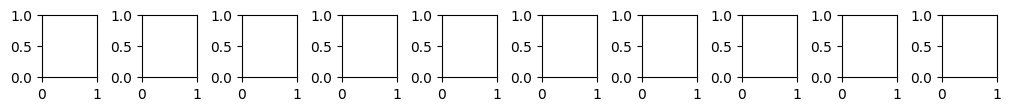

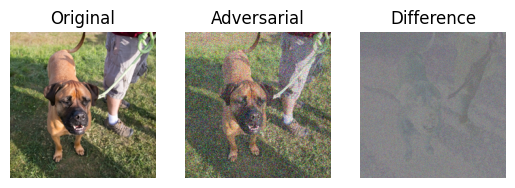

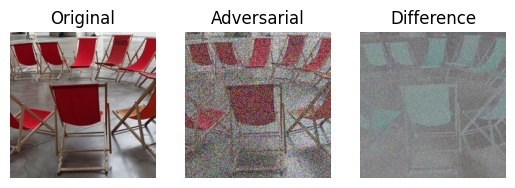

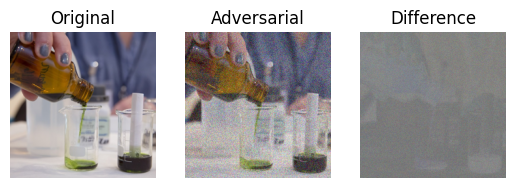

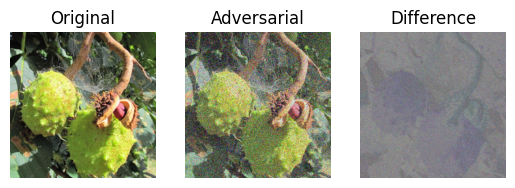

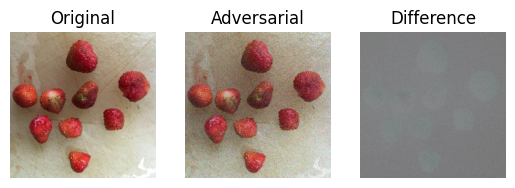

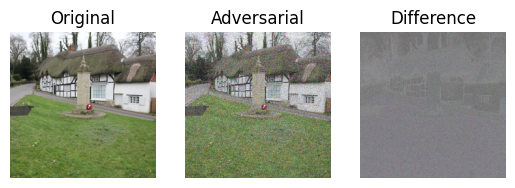

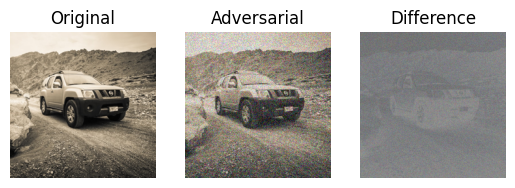

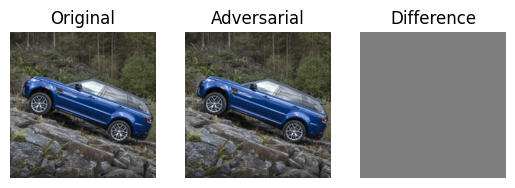

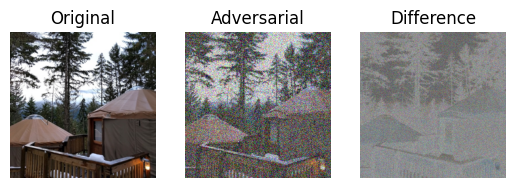

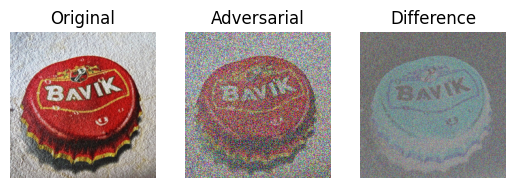

In [ ]:
# need to comment out the attacks that are not wanted to be observed, can only show one attack's results at a time

print("LinearSearchBlendedUniformNoiseAttack ACCURACY: ", fb.utils.accuracy(fmodel, clipped, labels))
difference = clipped - images
difference = difference / abs(difference).max() * 0.2 + 0.5
imagesFunction(images, clipped, difference)

print("L2ContrastReductionAttack ACCURACY: ", fb.utils.accuracy(fmodel, clipped2, labels))
difference = clipped2 - images
difference = difference / abs(difference).max() * 0.2 + 0.5
imagesFunction(images, clipped2, difference)

print("LinfFastGradientAttack ACCURACY: ", fb.utils.accuracy(fmodel, clipped3, labels))
difference = clipped3 - images
difference = difference / abs(difference).max() * 0.2 + 0.5
imagesFunction(images, clipped3, difference)


In [ ]:
# from StackOverflow guide to turn text file into a dictionary
d = {}
with open("/content/imagenetlabels.txt") as f:
    for line in f:
       (key, val) = line.split()
       d[int(key)] = val

In [ ]:
# showing what the labels were before change and then showing the labels after adversarials were put through
images_, labels_ = ep.astensors(images, labels)
predictions = fmodel(images_).argmax(axis=-1)

printStatement = ""
for i in predictions.numpy():
  printStatement += d[i] + " | "
print(predictions.numpy(), " = ", printStatement)

images_, labels_ = ep.astensors(clipped, labels)
predictions = fmodel(images_).argmax(axis=-1)

printStatement = ""
for i in predictions.numpy():
  printStatement += d[i] + " | "
print(predictions.numpy(), " = ", printStatement)


images_, labels_ = ep.astensors(clipped2, labels)
predictions = fmodel(images_).argmax(axis=-1)

printStatement = ""
for i in predictions.numpy():
  printStatement += d[i] + " | "
print(predictions.numpy(), " = ", printStatement)


images_, labels_ = ep.astensors(clipped3, labels)
predictions = fmodel(images_).argmax(axis=-1)

printStatement = ""
for i in predictions.numpy():
  printStatement += d[i] + " | "
print(predictions.numpy(), " = ", printStatement)

[243 559 438 990 949 853 609 511 915 455]  =  'bullmastiff' | 'foldingchair' | 'beaker' | 'buckeye,horsechestnut,conker' | 'strawberry' | 'thatch,thatchedroof' | 'jeep,landrover' | 'convertible' | 'yurt' | 'bottlecap' | 
[182 411 804 955 957 660 751 511 672 107]  =  'Borderterrier' | 'apron' | 'soapdispenser' | 'jackfruit,jak,jack' | 'pomegranate' | 'mobilehome,manufacturedhome' | 'racer,racecar,racingcar' | 'convertible' | 'mountaintent' | 'jellyfish' | 
[179 755 680 956 952 660 864 511 716 746]  =  'Staffordshirebullterrier,Staffordshirebullterrier' | 'radiotelescope,radioreflector' | 'nipple' | 'custardapple' | 'fig' | 'mobilehome,manufacturedhome' | 'towtruck,towcar,wrecker' | 'convertible' | 'picketfence,paling' | 'puck,hockeypuck' | 


'\nimages_, labels_ = ep.astensors(clipped3, labels)\npredictions = fmodel(images_).argmax(axis=-1)\n\nprintStatement = ""\nfor i in predictions.numpy():\n  printStatement += d[i] + " | "\nprint(predictions.numpy(), " = ", printStatement)\n'